### Проект "Методы с шагом Поляка"

В статье рассматривался шаг Поляка для задач комплексной оптимизации, доказывающий, что его простой вариант одновременно обеспечивает почти оптимальные скорости сходимости для алгоритма градиентного спуска для всех диапазонов сильной выпуклости, гладкости и параметров Липшица без предварительного знания этих параметров.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
from step_size import ConstantStepSize, SeqStepSize, StepSize
from IPython.display import Image 

In [2]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

### Реализуем 3 метода с использованием шага Поляка:
    1) метод Градиентного спуска с шагом Поляка
    2) метод Градиентного спуска с шагом Поляка (задана нижняя граница вместо минимального значения функционала)
    3) метод Адаптивного спуска с шагом Поляка

Мы рассматриваем минимизацию непрерывной выпуклой функции над евклидовым пространством f: $R_d -> R$ методом  градиента. Мы говорим, что f является α-сильно выпуклым тогда и только тогда, когда ∀x, y:

$$f(y) \geq f(x) + \nabla f(x)(y-x) + 0.5\alpha \|x-y\|^2 $$

Мы говорим, что f является β гладким тогда и только тогда, когда ∀x, y:

$$f(y) \leq f(x) + \nabla f(x)(y-x) + 0.5\beta \|x-y\|^2 $$


### Обозначения:
$x^* = \arg\min_{x \in R^d} {\{f(x)\}}$ 

$f(x^*)$$ — известное минимальное значение функционала

$h(x_t) = h_t = {f(x_t) - f(x^*)}$  — Оптимальное расстояние

$d_t={\|x_t - x^*\|}$  — Евклидово расстояние 

$\nabla_t = \nabla f(x_t)$  — Градиент

$\|\nabla_t\|^2$  — Квадрат евклидовой нормы

Следующие основные свойства для сильно выпуклых $\alpha$ - функций и/или $\beta$ - гладких функций (доказано для полноты в лемме 4):
$0.5\alpha d^2_t \leq h_t \leq 0.5\beta d^2_t$, $\frac{\|\nabla_t\|^2}{2\beta} \leq h_t \leq \frac{\|\nabla_t\|^2}{2\alpha}$ 

и $\frac{\|\nabla_t\|^2}{4\beta^2} \leq d^2_t \leq \frac{\|\nabla_t\|^2}{4\alpha^2}$

Следующая стандартная лемма лежит в основе большей части анализа выпуклой оптимизации первого порядка.

Лемма 1. Последовательность итераций, полученных с помощью проекционного градиентного спуска ($x_{t+1} =x_t −\eta_t \nabla f(x_t)$), удовлетворяет:

$$d^2_{t+1} \leq d^2_t - 2\eta_t h_t + \eta_t^2 \|\nabla_t\|^2$$

### Главные результаты
Поляк Борис утверждал, что в некотором смысле оптимальный выбор размера шага $\eta_t$ должен как можно быстрее уменьшать верхнюю границу $d^2_{t+1}$. 
Выбор шага оказался таким: 
$$\eta_t = \frac{h_t}{\|\nabla_t\|^2} $$
что приводит к снижению $d^2_{t}$ на
$$d^2_{t+1} \leq d^2_{t} - \frac{h_t}{\|\nabla_t\|^2}$$
Обратите внимание, что этот выбор использует знание $f(x^*)$, так как $h_t = {f(x_t) - f(x^*)}$

Борис Поляк показал, что этот выбор был оптимальным для негладкой выпуклой оптимизации.

In [3]:
###  Градиентный спуск
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-9, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(x-x_prev) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x


In [4]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

### Шаг Поляка для GD: $\eta_k=\frac{h_t}{\|\nabla_t\|^2}$
### для Алгоритма 1 - метод Градиентного спуска с шагом Поляка

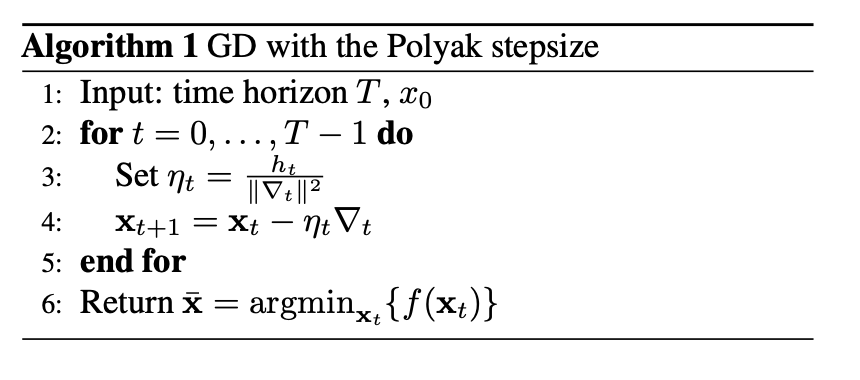

In [5]:
display(Image(filename='algos_1.png', width = 500)) 

In [6]:
class PolyakStepSize(StepSize):
    def __init__(self, f_sol=0):
        self.f_sol = f_sol
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x)-self.f_sol) / np.linalg.norm(gradf(x))**2

### Шаг Поляка для GD с нижней границей: $\alpha_k=\frac{f_k-\widetilde{f}}{2\|g_k\|^2}$
### для Алгоритма 2 - метод Градиентного спуска с шагом Поляка (задана нижняя граница вместо минимального значения функционала)

Без знания оптимальной величины $f(x^*)$, наш второй основной результат показывает, что все, что нам нужно - это нижняя граница $\widetilde{f_0} \leq f(x^*)$, и мы можем сделать почти так же, как в точном шаге Поляка.

$\widetilde{f}$ - заданная нижняя граница

Обратим внимание, что в некоторых случаях значение $\widetilde{f}$ = 0 является допустимой нижней границей (например, в эмпирических настройках минимизации риска)

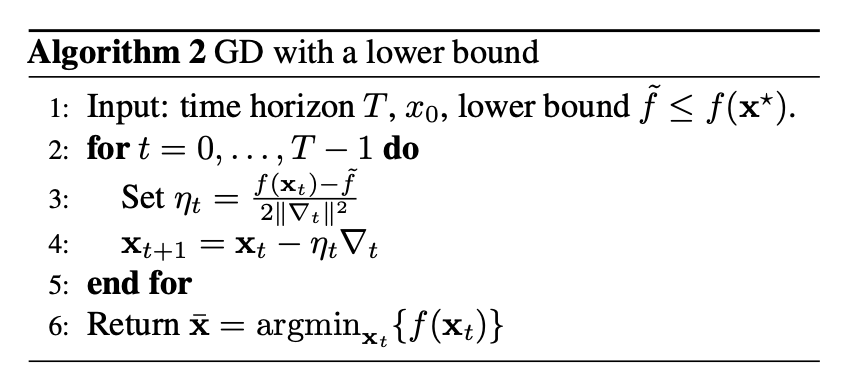

In [7]:
display(Image(filename='algos_2.png', width = 500)) 

In [8]:
class PolyakStepSizeWithLowerBound(StepSize):
    def __init__(self, f_sol=0):
        self.f_sol = f_sol
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        return (f(x)-self.f_sol) / (2*np.linalg.norm(gradf(x))**2)

### Алгоритм 3 (метод Адаптивного спуска с шагом Поляка) включает в себя запуск Алгоритма 2 для каждой эпохи

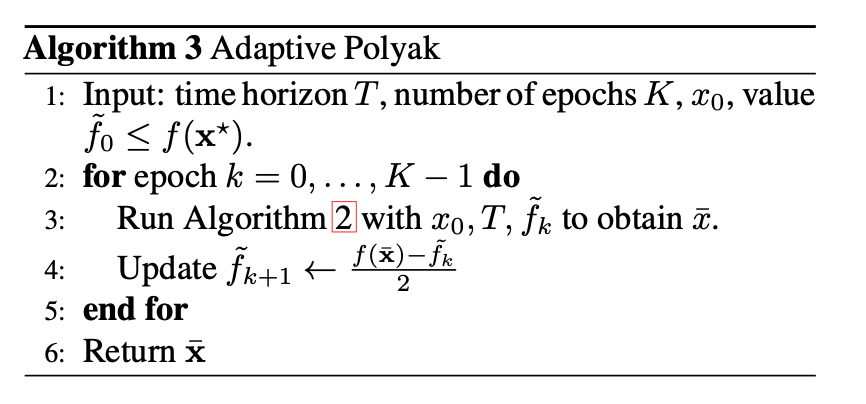

In [9]:
display(Image(filename='algos_3.png', width = 500)) 

In [10]:
class AdaptivePolyak:
    def __init__(self, return_history=True, name=None):
        self.name = name
        #self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-9, max_iter=10000, epoch = 2000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        f_sol = 0
        f_sol_prev = None
        ep = 0
        while ep <= epoch:
            method = GradientDescent(PolyakStepSizeWithLowerBound(f_sol))
            x = method.solve(x, f, gradf, tol, max_iter)
            f_sol_prev, f_sol = f_sol, (f(x) - f_sol)/2
            ep+=1
            if ep >= epoch:
                break
            if self.return_history:
                self.history.append((x, time.time()))
        return x

### Рассмотрим на примере решения СЛАУ

$$\min_x \|Ax-b\|_1$$

In [11]:
def func(x, A, b):
    return np.abs(A.dot(x) - b).sum()

def grad_f(x, A, b):
    y = (A.dot(x) - b)
    return A.T @ np.sign(y)

In [12]:
np.random.seed(1)
n = 500
m = 100
A = np.random.randn(m, n)
x_true = np.random.rand(n)
b = A.dot(x_true)
x0 = np.ones(n)
f = lambda x: func(x, A, b)
gradf = lambda x: grad_f(x, A, b)

In [13]:
methods = [
          GradientDescent(PolyakStepSize(0), name="GD, Polyak"),
          GradientDescent(PolyakStepSizeWithLowerBound(0), name="GD, Polyak with lower bound = 0"),
          GradientDescent(PolyakStepSizeWithLowerBound(-1), name="GD, Polyak with lower bound = -1"),
          AdaptivePolyak(PolyakStepSizeWithLowerBound(0), name="AP, Polyak"),
          ]

In [14]:
for method in methods:
    method.solve(x0, f, gradf, tol=1e-9, max_iter=10000)

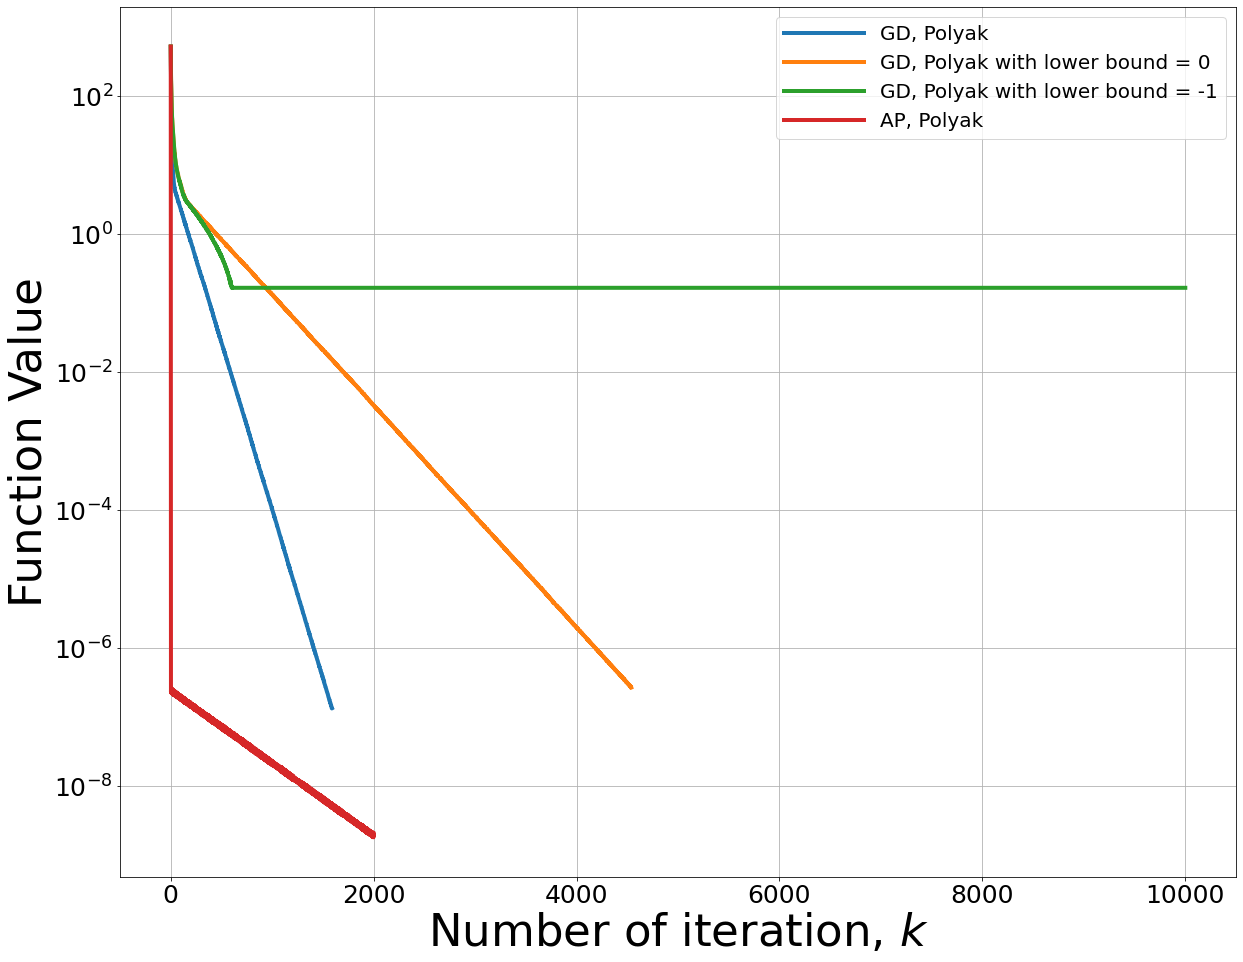

In [15]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1/2 * np.linalg.norm(A @ x -b, 1)
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

### Алгоритм 3 (метод Адаптивного спуска с шагом Поляка) достигает высокой точности при малых итерациях по сравнению с остальными

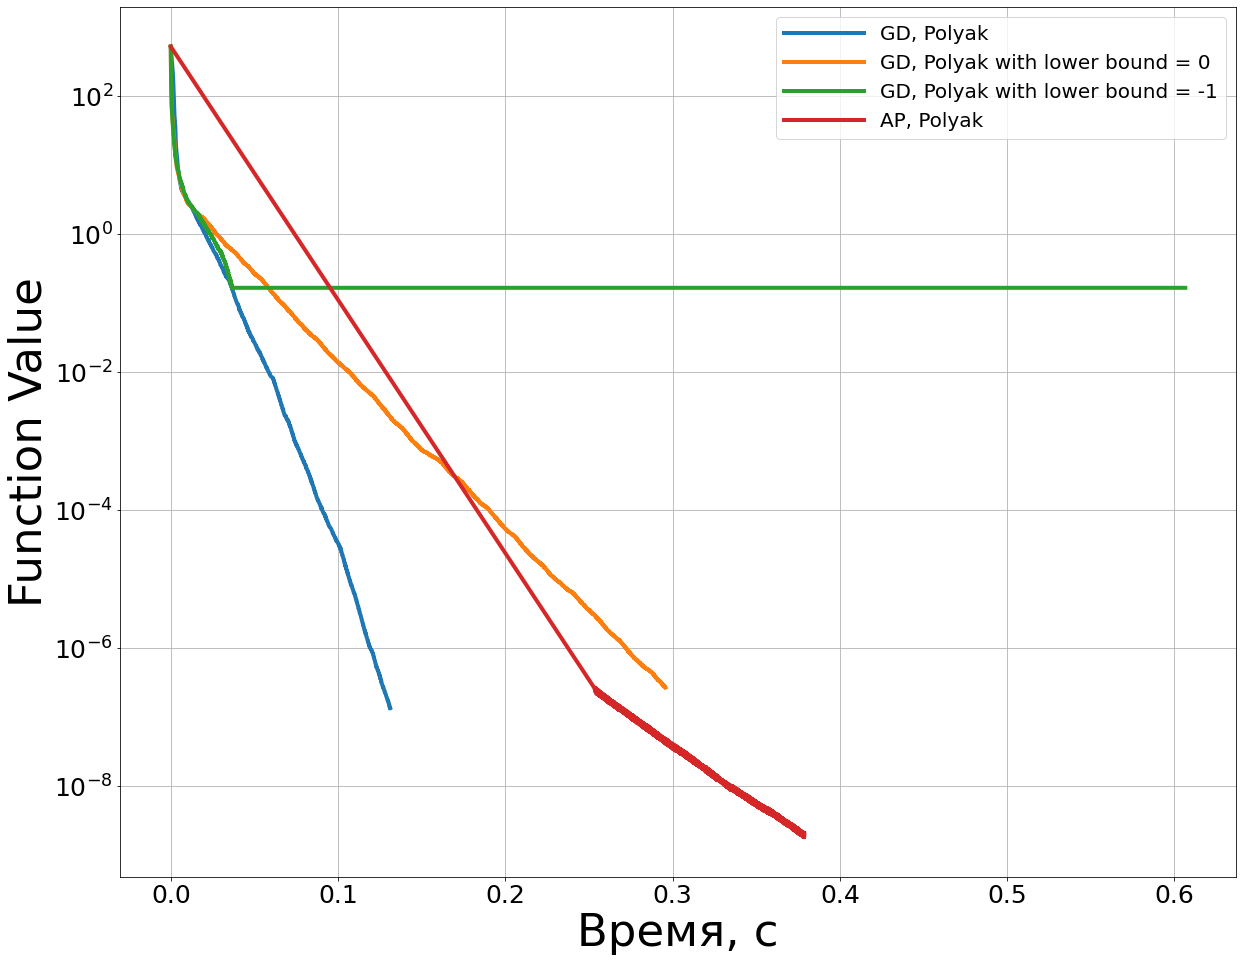

In [16]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: 1/2 * np.linalg.norm(A @ x -b, 1)
#funcx = lambda x: f(x)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=True, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Function Value")
plt.xlabel(r"Время, с")
plt.legend()

### Алгоритм 3 (метод Адаптивного спуска с шагом Поляка) достигает высокой точности медленнее, чем остальные методы, но учитывая обращение к Алгоритму 2 на каждой эпохе - это логично